## Advanced Lane Line Finding using Images

In this notebook, we are going to build a computer vision model for identifying lane lines in road images. 
1. Camera calibration
2. Extracting lane line pixels using color thresholding 
3. Perspective transformation
4. Calculating lane curvature
5. Producing output images and videos with highlighted lane lines

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import glob
import os
from moviepy.editor import VideoFileClip

import advanced_lane_finding

plt.style.use('seaborn-white')

%matplotlib inline

###  1. Camera Calibration
Camera calibration logic is encapsulated in **`CameraCalibrator`** class in the **`advanced_lane_finding.py`** module. This class's constructor takes following arguments.

1. A list of camera images which we are going to use for camera calibration. (Usually, we use chessboard images)
2. Number of corners in X direction
3. Number of corners in Y direction
4. A boolean flag, if it is True, we do camera calibration and store those calibration data. 

The public method of this **`CameraCalibrator`** class is **`undistort`** and it takes a distorted image as the input and produces an undistorted image.

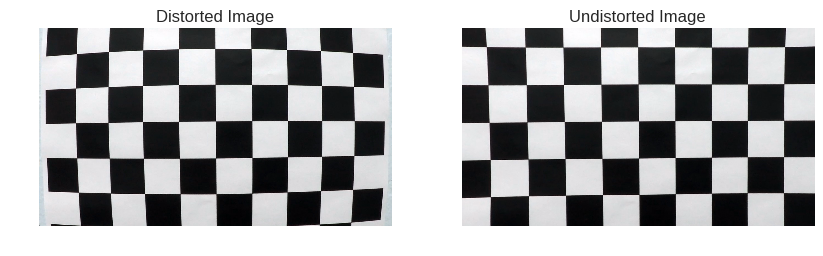

In [2]:
%load_ext autoreload
%autoreload 2

# Camera calibration 
calibration_images = glob.glob('../camera_cal/calibration*.jpg')
calibrator = advanced_lane_finding.CameraCalibrator(calibration_images,
                                                   9, 6,
                                                   use_existing_camera_coefficients = True)

# Take example distorted image and undistort it using saved camera coefficients
distorted_image = '../camera_cal/calibration1.jpg'
distorted_image = cv2.imread(distorted_image)
undistorted_image = calibrator.undistort(distorted_image)

# Display both distorted and undistorted images
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Distorted Image')
plt.imshow(distorted_image)


plt.subplot(1, 2, 2)
plt.imshow(undistorted_image)
plt.axis('off')
plt.title('Undistorted Image')

plt.show()

In the next code block, we use **`undistort`** method to remove distortion of all checkboard images.

In [3]:
%load_ext autoreload
%autoreload 2

# Distortion correction looks OK, 
# now I’m going to save all undistorted images to 
# ./output_images/undistorted folder

UNDISTORTED_DEST_LOCATION = '../output_images/camera_cal/'

calibration_images = glob.glob('../camera_cal/calibration*.jpg')

for image in calibration_images:
    start = image.rindex('/') + 1
    end = image.rindex('.')
    dest_path = UNDISTORTED_DEST_LOCATION + image[start:end] + '.jpg'
    
    image = cv2.imread(image)
    undistorted_image = calibrator.undistort(image)
    # Save undistorted image
    cv2.imwrite(dest_path, undistorted_image)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now our camera calibration class is ready and it will be the first step in the process of finding road lane line using camera images. 

Follwing image shows before and after applying distortion correction to a typical road image. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


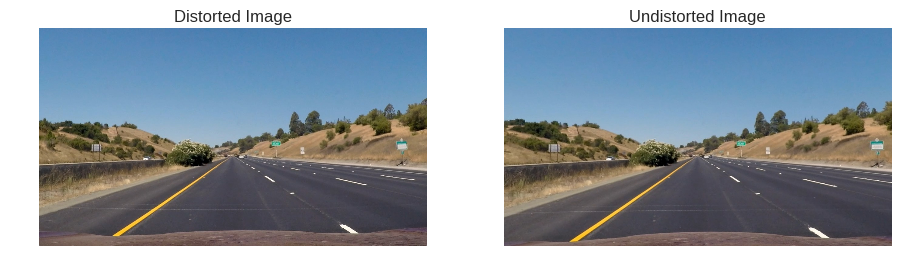

In [4]:
%load_ext autoreload
%autoreload 2

# Next, we are going to apply distortion correction to testing images

sample_image = '../test_images/straight_lines1.jpg'
sample_image = cv2.imread(sample_image)
straight = calibrator.undistort(sample_image)

plt.figure(figsize=(11, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title('Distorted Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(straight, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')
plt.axis('off')

plt.show()

In [5]:
%load_ext autoreload
%autoreload 2

# Next we are going to save distrotion corrected images to 
# ./output_images/test_images_ undistorted folder

UNDIST_IMAGES_LOCATION = '../output_images/undistorted_test_images/'
TEST_IMAGES_LOCATION = '../test_images/'
images_loc = os.listdir(TEST_IMAGES_LOCATION)

for image_loc in images_loc:
    corred_image_file = UNDIST_IMAGES_LOCATION + image_loc
    distorted_image_location = TEST_IMAGES_LOCATION + image_loc
    distorted_image_location = cv2.imread(distorted_image_location)
    corrected_image = calibrator.undistort(distorted_image_location)
    cv2.imwrite(corred_image_file, corrected_image)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###  2. Extracting Lane Line Pixels Using Color Thresholding

Correctly identifying lane line pixels is one of the main tasks of this project. In order to identify lane line, we have used three main techniques namely:

1. Sobel operation in X direction
2. Color thresholding in S component of the HLS color space.
3. Color thresholding in L component of the HLS color space.

These three operations are encapsulated in the method called **`binarize`** in **`advanced_lane_finding.py`** module located in **`$PROJECT_HOME/src`** folder.

Also, below shows the `binarize` operation applied to a sample image.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


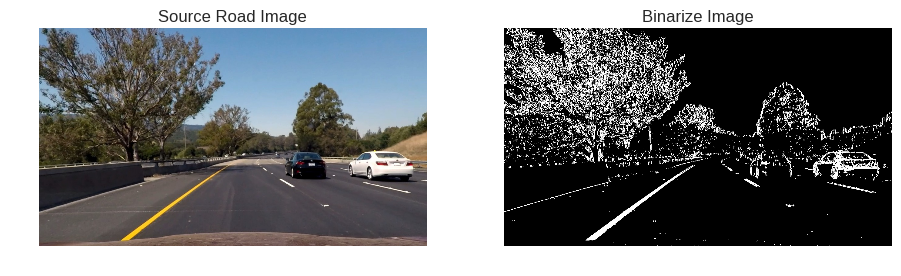

In [6]:
%load_ext autoreload
%autoreload 2

# Now we are ready to do color thresholding and masking 
# in order to find out binary images with lane lines.
saved_undistorted_img = mpimg.imread('../output_images/undistorted_test_images/test6.jpg')
binary_img = advanced_lane_finding.binarize(saved_undistorted_img,
                                                 gray_thresh = (20, 255), 
                                                 s_thresh = (170, 255), 
                                                 l_thresh = (30, 255))
plt.figure(figsize=(11, 6))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Source Road Image')
plt.imshow(saved_undistorted_img)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Binarize Image')
plt.imshow(binary_img)

plt.show()

In [7]:
%load_ext autoreload
%autoreload 2

# Next we are going to save all binary threshold image to
# ./output_images/test_images_binary folder

OUTPUT_DIR = '../output_images/test_images_binary/'
INPUT_DIR = '../output_images/undistorted_test_images/'

for file in os.listdir(INPUT_DIR):
    saved_undistorted_img = mpimg.imread(INPUT_DIR + file)
    binary_img = advanced_lane_finding.binarize(saved_undistorted_img,
                                                 gray_thresh = (20, 255), 
                                                 s_thresh = (150, 255), 
                                                 l_thresh = (120, 255))
    cv2.imwrite(OUTPUT_DIR + file, binary_img)
print('{} images saved to {} directory'.format(len(os.listdir(INPUT_DIR)),
                                              OUTPUT_DIR))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
8 images saved to ../output_images/test_images_binary/ directory


### 3. Perspective Transformation

The second step of the lane line finding pipeline is "perspective transformation" step. In an image perspective is the phenomenon where objects appear smaller the further away they are from a viewpoint.   

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. In the project we are going to use bird’s-eye view transform that allows us to view a lane from above; this will be useful for calculating the lane curvature in step 4.

Warped operation is encapculated in **`PerspectiveTransformer`** class of the **`advanced_lane_finding.py`** package located in **`$PROJECT_HOME/src`** folder. In order to create an instance of **`PerspectiveTransformer`**  class we need to provide four source and destination points. In order to clearly visible lane lines we have selected following source and destination points. 

|Source Points | Destination Points|
|--------------|-------------------|
|(253, 697)      |    (303, 697)       |
|(585, 456)      |(303, 0)             |
|(700, 456)      |(1011, 0)            |
|(1061, 690)     |(1011, 690)          |


I verified the performance of my perspective transformation by transforming an image (**`../output_images/undistorted_test_images/straight_lines2.jpg`**) using above source and destination points as given below.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


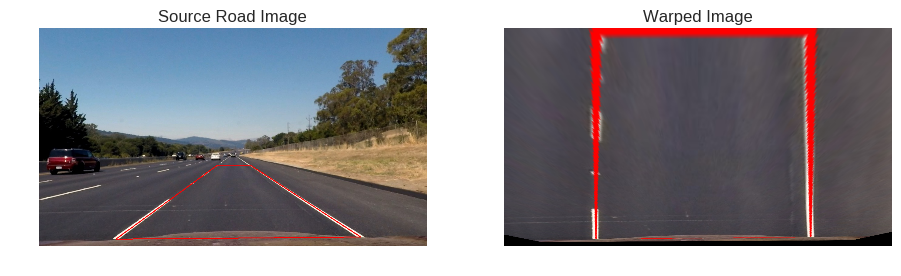

In [8]:
%load_ext autoreload
%autoreload 2

image = mpimg.imread('../output_images/undistorted_test_images/straight_lines2.jpg')

corners = np.float32([[253, 697],[585,456],[700, 456],[1061,690]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]

img_size = (image.shape[1], image.shape[0])
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])

perspective = advanced_lane_finding.PerspectiveTransformer(src, dst)


cv2.line(image, (253, 697), (585,456), color=[255,0,0], thickness=2)
cv2.line(image, (585,456), (700, 456), color=[255,0,0], thickness=2)
cv2.line(image, (700, 456), (1061,690), color=[255,0,0], thickness=2)
cv2.line(image, (1061,690), (253, 697), color=[255,0,0], thickness=2)

warped_img = perspective.transform(image)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Source Road Image')
plt.imshow(image)


plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Warped Image')
plt.imshow(warped_img)

plt.show()

The following section shows how perspective transformation and binarizing work when they applied to our test images.

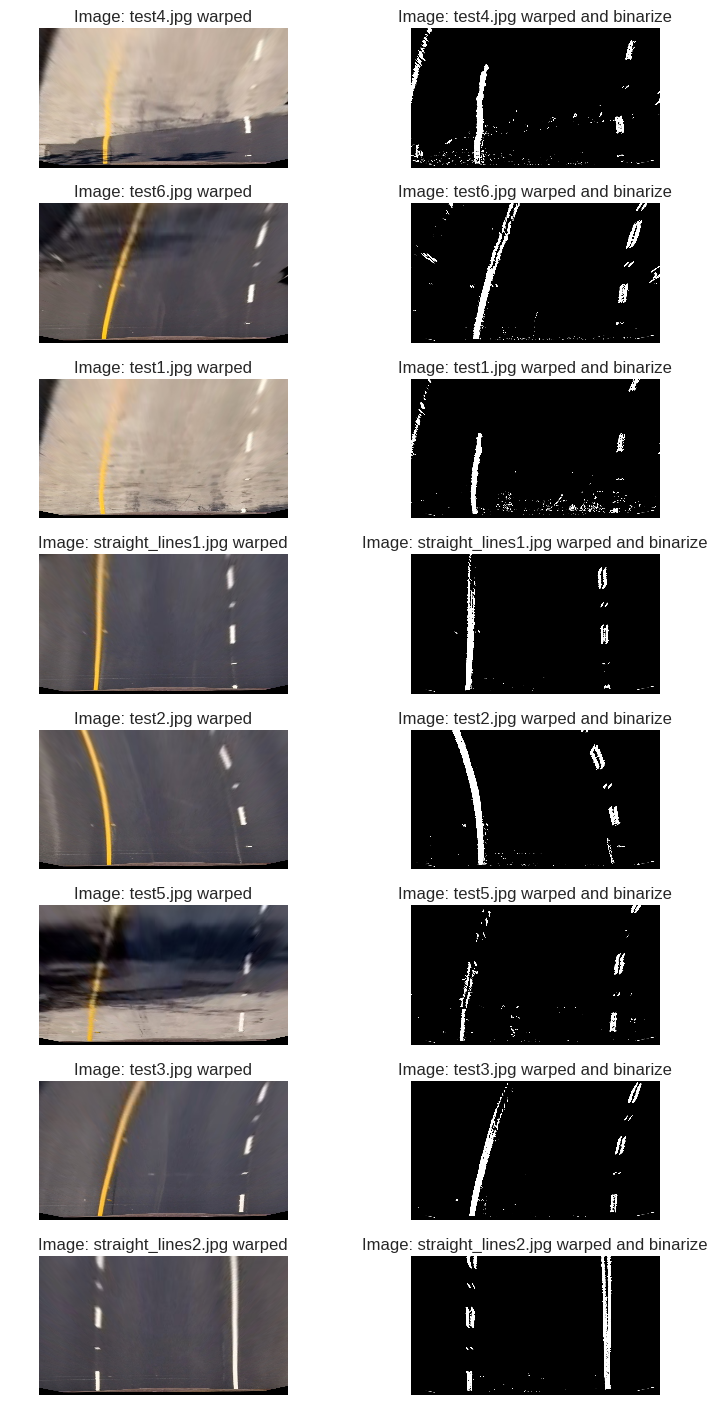

In [9]:
index = 0
plt.figure(figsize=(8, 18))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.5, hspace=0.05)

binary_images = []
for file in os.listdir('../output_images/undistorted_test_images/'):
    image = mpimg.imread('../output_images/undistorted_test_images/' + file)
        
    ax1 = plt.subplot(gs[index])
    undistorted = perspective.transform(image)
    ax1.axis('off')
    ax1.set_title('Image: {} warped'.format(file))
    ax1.imshow(undistorted)
    
    index += 1
    
    binary_img = advanced_lane_finding.binarize(undistorted)
    binary_images.append(binary_img)
    ax2 = plt.subplot(gs[index])
    ax2.axis('off')
    ax2.set_title('Image: {} warped and binarize'.format(file))
    ax2.imshow(binary_img)
    
    index += 1
    
plt.show()

### 4. Calculating Lane Curvature
Now we have extracted lane line pixels. So next step would be calculating the road curvature and other necessary quantities (such as how much the vehicle off from the center of the lane)

In order to calculate road curvature, we have used two methods as given below.
1. `naive_lane_extractor(self, binary_warped)` (inside the **Line** class in advanced_line_finding module)
2. `smart_lane_extractor(self, binary_warped)` (inside the **Line** class in advanced_line_finding module

Both methods take a binary warped image (similar to one shown above) and produces X coordinates of both left and right lane lines. `naive_lane_extractor(self, binary_warped)` method uses **sliding window** to identify lane lines from the binary warped image and then uses a second order polynomial estimation technique to calculate road curvature. 

In following code blocks, explain the algorith we used in the **`naive_lane_extractor(self, binary_warped)`** method.

* **`naive_lane_extractor(self, binary_warped)`** algorithm expects a binary warped image such as one shown below.

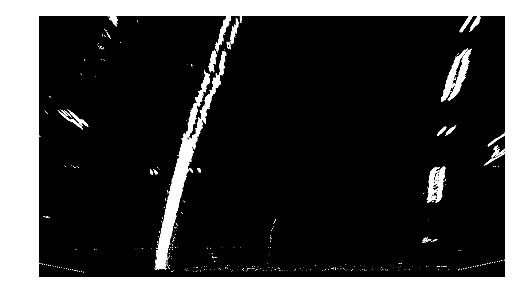

In [10]:
warped_image = binary_images[1] 
plt.imshow(warped_image)
plt.axis('off')
plt.show()

* Next, we calculate a histogram of pixel intencities using the first half (starting from the bottom of the image) the image as shown below.

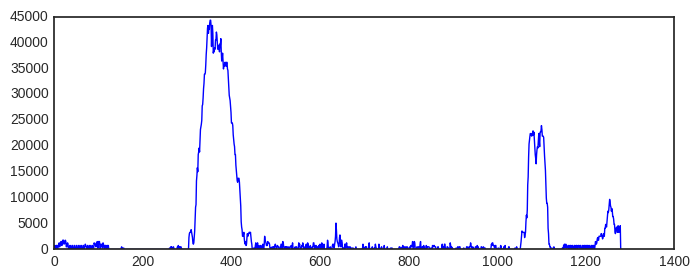

In [11]:
histogram = np.sum(warped_image[warped_image.shape[0] // 2:, :, 0], axis=0)
plt.figure(figsize=(8, 3))
plt.plot(histogram)
plt.show()

Next, we calculate the mid point of the histogram and next peack point of left and right haves are calculated.

In [12]:
midpoint = np.int(histogram.shape[0] / 2)

# get left and right halves of the histogram
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print('Peak point of left half: {}'.format(leftx_base))
print('Peak point of right half: {}'.format(rightx_base))

Peak point of left half: 352
Peak point of right half: 1100


Next, we need to calculate
* Number of windows we going to use
* X and Y coordinates of lane line pixels

Also, we assign **`leftx_current`** and **`rightx_current`** to the previously calculated peak points. Finally, two containers (**`left_lane_inds`** and **`right_lane_inds`**) are created to store lane line coordinates.

In [13]:
nwindows = 9
window_height = np.int(warped_image.shape[0] / nwindows)

# Extracts x and y coordinates of non-zero pixels
nonzero = warped_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Set current x coordinated for left and right
leftx_current = leftx_base
rightx_current = rightx_base

margin = 75
min_num_pixels = 35

# save pixel ids in these two lists
left_lane_inds = []
right_lane_inds = []

Following code block does the main task of lane curvature calculation process. 

1. It iterate **`nwindows`** times and in each iteration:
2. Search rectangle reagons near the **`leftx_current`** and **`rightx_current`** and find white pixel ids and addd thoese ids to **`left_lane_inds`** and **`right_lane_inds`** arrays.
3. Also, we updated **`leftx_current`** and **`rightx_current`** variables.
4. Calcuate X and Y coordinates of the white pixels those are belonging to left and right lane lines.
5. Next, using those calculated X and Y coordinates we fit a second order polynomial.
5. Using calculated polynomial coefficients, we caculate X coordinate of the lane line for each Y coordinate.

Finally, we draw polynomial lines and calcuated lane line pixels for one of the testing images in order to verify our algorithm.

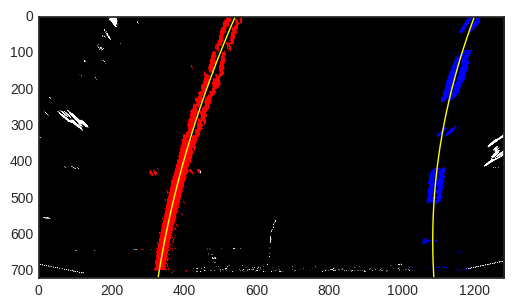

In [14]:
for window in range(nwindows):
    win_y_low = warped_image.shape[0] - (window + 1) * window_height
    win_y_high = warped_image.shape[0] - window * window_height

    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    if len(good_left_inds) > min_num_pixels:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > min_num_pixels:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the ndarrays of indices
left_lane_array = np.concatenate(left_lane_inds)
right_lane_array = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_array]
lefty = nonzeroy[left_lane_array]
rightx = nonzerox[right_lane_array]
righty = nonzeroy[right_lane_array]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

fity = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0])
fit_leftx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
fit_rightx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]


warped_image[nonzeroy[left_lane_array], nonzerox[left_lane_array]] = [255, 0, 0]
warped_image[nonzeroy[right_lane_array], nonzerox[right_lane_array]] = [0, 0, 255]
plt.imshow(warped_image)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In addition to the identifying road curvate, we calculate actual road curvature (in meters) and we calculate how much the vehicle is drifted from the center of the lane. These two calculation are done inside the **`calculate_road_info(self, image_size, left_x, right_x)`** method of the **`Lane`** class.

### 5. Producing output images and videos with highlighted lane lines

In order to easy work with images as well as videos, we have created a Python class called **`Line`** inside the **`advanced_lane_finding`** module. It encapsulates all the methods we described above and few more helper methods as well.  

The key method of **`Line`** class is **`process(self, image)`** method. It takes a single image as the input. That image goes through the image process pipeline as described above and finally produces another image which contains highlighted lane line, lane line curvature information and the content of the original image.

The following code block shows how we can use it with road images.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


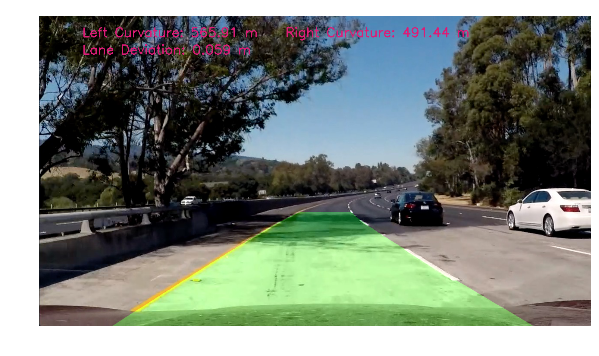

In [15]:
%load_ext autoreload
%autoreload 2

src_image = mpimg.imread('../test_images/test5.jpg')

line = advanced_lane_finding.Line()
output_image = line.process(src_image)

plt.figure(figsize=(10, 4))
plt.axis('off')
plt.imshow(output_image)
plt.show()

Finally, we are going to apply out lane finding algorithm against a sample video clip as shown below.

In [16]:
%load_ext autoreload
%autoreload 2

output_file = '../processed_project_video.mp4'
input_file = '../project_video.mp4'
line = advanced_lane_finding.Line()

clip = VideoFileClip(input_file)
out_clip = clip.fl_image(line.process) 
out_clip.write_videofile(output_file, audio=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[MoviePy] >>>> Building video ../processed_project_video.mp4
[MoviePy] Writing video ../processed_project_video.mp4


100%|█████████▉| 1260/1261 [02:21<00:00,  9.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../processed_project_video.mp4 

